# 0. Tải bộ dữ liệu wifi_localization
(**Lưu ý:** nếu không tải được do bị giới hạn số lượt tải, các bạn hãy tải thủ công lên drive và copy vào colab)

In [1]:
# https://drive.google.com/file/d/1eCqW1U0djlHxREQETL4gsYC3pE-Ngihx/view?usp=share_link
!gdown --id 1eCqW1U0djlHxREQETL4gsYC3pE-Ngihx

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1eCqW1U0djlHxREQETL4gsYC3pE-Ngihx
To: /content/wifi_localization.zip
100% 14.1k/14.1k [00:00<00:00, 10.2MB/s]


In [2]:
!unzip 'wifi_localization.zip'

Archive:  wifi_localization.zip
  inflating: wifi_localization.csv   


# 1. Tiền xử lý dữ liệu

## 1.1. Đọc dữ liệu

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm 

# Khai báo đường dẫn đến file dataset
dataset_path = "./wifi_localization.csv"
## Đọc dữ liệu file .csv sử dụng np.genfromtxt()
# Đọc dataset
dataset = np.genfromtxt(dataset_path, # Đường dẫn dataset
                        delimiter=",", # Kí tự ngăn cách giữa các cột
                        skip_header=1, # Bỏ qua hàng đầu tiên (chứa tên của cột)
                        dtype=None, # dtype=None sẽ ép hàm genfromtxt phải tìm kiểu dữ liệu của từng cột một cách tuần tự
                        encoding=None) # Tắt tính năng mã hóa dữ liệu sang bytes

In [4]:
n_samples = dataset.shape[0] # Đọc số lượng mẫu dữ liệu trong dataset (bằng số hàng trong file csv)
n_classes = len(np.unique(dataset[:, -1])) # Đọc số lượng lớp đối tượng dự đoán trong dataset (bằng số lượng giá trị duy nhất của cột cuối cùng trong file .csv)
n_features = dataset.shape[1] - 1 # Đọc số lượng đặc trưng của bộ dữ liệu (bằng số cột trừ cột cuối cùng trong file .csv)
print('Số lượng mẫu dữ liệu (samples): ', n_samples)
print('Số lượng đặc trưng (features): ', n_features)
print('Số lượng lớp đối tượng (classes): ', n_classes)

Số lượng mẫu dữ liệu (samples):  2000
Số lượng đặc trưng (features):  7
Số lượng lớp đối tượng (classes):  4


## 1.2. Trộn dữ liệu, tách independent/dependent variable, thêm bias, one hot encoding label, chuẩn hóa dữ liệu

In [5]:
# Trộn (shuffle) dữ liệu
np.random.seed(1) # Cố định kết quả random 
dataset = np.random.permutation(dataset)
# Tách independent varaible và depedent variable thành 2 biến X, y
X, y_idx = dataset[:, :-1].astype(np.float64), dataset[:, -1].astype(np.int32)
# One hot encoding label
y = np.array([np.zeros(n_classes) for _ in range(y_idx.shape[0])])
y[np.arange(len(y_idx)), y_idx] = 1
# Chuẩn hóa dữ liệu bằng phương pháp min-max normalization
X_min = np.min(X, axis=0)
X_max = np.max(X, axis=0)
X = (X - X_min) / (X_max - X_min)
# Tạo ma trận 1 (tượng trưng cho bias của mỗi sample)
bias = np.ones((X.shape[0], 1))
# Thêm bias vào X
X = np.hstack((X, bias))

## 1.3. Chia tập Train/Val/Test

In [6]:
# Khai báo tỉ lệ kích thước của tập train/val/test (không nhất thiết khai báo cho test)
TRAIN_SIZE = 0.7
VAL_SIZE = 0.2

# Tính chỉ mục kết thúc của train, test
TRAIN_IDX_END = int(TRAIN_SIZE * dataset.shape[0])
VAL_IDX_END = int(TRAIN_IDX_END + (VAL_SIZE * dataset.shape[0]))

# Chia train/val/test sử dụng kĩ thuật indexing
X_train, y_train = X[:TRAIN_IDX_END], y[:TRAIN_IDX_END]
X_val, y_val = X[TRAIN_IDX_END:VAL_IDX_END], y[TRAIN_IDX_END:VAL_IDX_END]
X_test, y_test = X[VAL_IDX_END:], y[VAL_IDX_END:]

# 2. Xây dựng model

## 2.1. Khai báo hàm tính softmax

In [7]:
# Xây dựng hàm dự đoán của model dùng softmax
def softmax(Z):
  exp_Z = np.exp(Z)

  return exp_Z / exp_Z.sum(axis=1)[:, None]

## 2.2. Khai báo hàm dự đoán

In [8]:
# Xây dựng hàm dự đoán sử dụng softmax
def predict(X, theta):
  Z = np.dot(X, theta) # Tính tích vô hướng
  y_hat = softmax(Z) # Tính softmax

  return y_hat

## 2.3. Khai báo hàm tính loss (cross entropy)

In [9]:
# Xây dựng hàm loss cross entropy
def loss(y, y_hat):

  return (-1 / y.shape[0]) * np.sum(y * np.log(y_hat))

## 2.4. Khai báo hàm tính gradient

In [10]:
# Xây dựng hàm tính gradient
def gradient(X, y, y_hat):

  return np.dot(X.T, (y_hat - y)) / y.size

## 2.5. Khai báo hàm đánh giá 

In [11]:
# Xây dựng hàm đánh giá
def evaluate(X_test, y_test, theta):
  y_hat = predict(X_test, theta) # Dự đoán trên mẫu dữ liệu tập test
  test_loss = loss(y_test, y_hat) # Tính loss giữa y_hat và y_test
  test_acc = (np.argmax(y_hat, axis=1) == np.argmax(y_test, axis=1)).mean() # Tính accuracy giữa y_hat và y_test
  
  return test_loss, test_acc

## 2.6. Khai báo hàm training

In [12]:
# Xây dựng hàm training
def fit(X_train, y_train, theta, EPOCHS=10, LR=1e-4, BATCH_SIZE=32, is_visualize=False):
  train_losses = []
  for epoch in range(EPOCHS):
    progress_bar = tqdm(range(0, X_train.shape[0], BATCH_SIZE), desc=f"EPOCH {epoch}", position=0) # Tạo thanh progress thể hiện tiến độ training
    for i in progress_bar:
      # Đọc bộ mẫu dữ liệu tại batch i
      X_i = X_train[i:i+BATCH_SIZE]
      y_i = y_train[i:i+BATCH_SIZE]

      # Dự đoán mẫu dữ liệu Xi
      y_hat = predict(X_i, theta)

      # Tính train loss, train accuracy
      train_loss = loss(y_i, y_hat)
      train_losses.append(train_loss)

      # Tính gradient
      grad = gradient(X_i, y_i, y_hat)

      # Cập nhật trọng số
      theta = theta - LR * grad

      progress_bar.set_postfix({"Train Loss": train_loss}) # Thêm thông tin train loss vừa tính được vào thanh progress

  print("\nTRAINING COMPLETE")

  if is_visualize: # Plot đồ thị train loss nếu is_visualize = True
    plt.plot(train_losses, color='green')
    plt.title("Train loss over batch")
    plt.xlabel(f"Batch size {BATCH_SIZE}")
    plt.ylabel("Loss")
    plt.show()

  return theta

# 3. Huấn luyện model

In [13]:
# Khởi tạo bộ trọng số theta ngẫu nhiên (theo phân phối đồng nhất)
np.random.seed(1) # Cố định kết quả random 
theta = np.random.uniform(size=(X_train.shape[1], np.unique(y_train, axis=0).shape[0]))

EPOCH 499: 100%|██████████| 11/11 [00:00<00:00, 622.70it/s, Train Loss=0.478]



TRAINING COMPLETE


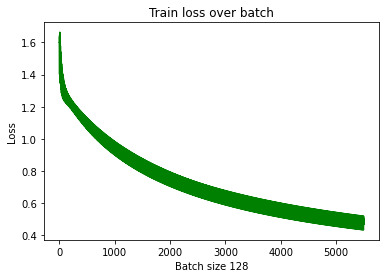

In [14]:
# Khai báo các siêu tham số (hyperparameters) và huấn luyện mô hình
EPOCHS = 500
LR = 1e-1
BATCH_SIZE = 128
theta = fit(X_train, y_train, theta, EPOCHS, LR, BATCH_SIZE, is_visualize=True)

# 4. Đánh giá model

In [15]:
# Đánh giá trên tập validation
val_loss, val_acc = evaluate(X_val, y_val, theta)
print("Validation loss: ", np.round(val_loss, 3))
print("Validation accuracy: ", np.round(val_acc, 3))

# Đánh giá trên tập test
test_loss, test_acc = evaluate(X_test, y_test, theta)
print("Test loss: ", np.round(test_loss, 3))
print("Test accuracy: ", np.round(test_acc, 3))

Validation loss:  0.483
Validation accuracy:  0.975
Test loss:  0.464
Test accuracy:  0.975
